**Step 1: Define the HP Memristor Activation**

In [1]:
import torch
import torch.nn as nn

class HPMemristorActivation(nn.Module):
    def __init__(self, Ron=1, Roff=600.0, D=7e-9, mu_v=1e-14):  # Oι τιμές του πραγματικού μοντέλου είναι: Ron=100, Roff=16000, D=10e-9
        super().__init__()
        self.Ron = Ron
        self.Roff = Roff
        self.D = D
        self.mu_v = mu_v

    def forward(self, x):
        i = torch.clamp(x, 0.0, 1.0)  # simulate input current
        dw_dt = self.mu_v * self.Ron / (self.D ** 2) * i
        w = torch.clamp(0.5 + dw_dt, 0.0, self.D)  # initial state = 0.5
        R = self.Ron * (w / self.D) + self.Roff * (1 - w / self.D)
        v = R * i
        return v

**Step 2: Define the Neural Network**

In [2]:
class MemNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.hp_act1 = HPMemristorActivation()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.hp_act2 = HPMemristorActivation()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.hp_act1(self.fc1(x))
        x = self.hp_act2(self.fc2(x))
        x = self.fc3(x)
        return x

**Step 3: Generate Lorenz System Data**

In [3]:
import numpy as np

def lorenz(x, y, z, s=10, r=28, b=2.667):
    x_dot = s * (y - x)
    y_dot = r * x - y - x * z
    z_dot = x * y - b * z
    return x_dot, y_dot, z_dot

def generate_lorenz_data(n_points=10000, dt=0.01):
    xs, ys, zs = [1.0], [1.0], [1.0]
    for _ in range(n_points - 1):
        x_dot, y_dot, z_dot = lorenz(xs[-1], ys[-1], zs[-1])
        xs.append(xs[-1] + x_dot * dt)
        ys.append(ys[-1] + y_dot * dt)
        zs.append(zs[-1] + z_dot * dt)
    return np.array([xs, ys, zs]).T

**Step 4: Training Loop**

In [4]:
from torch.utils.data import TensorDataset, DataLoader

data = generate_lorenz_data()
X = torch.tensor(data[:-1], dtype=torch.float32)
Y = torch.tensor(data[1:], dtype=torch.float32)
dataset = TensorDataset(X, Y)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

model = MemNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(300):
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        output = model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer.step()
    #print(f"Epoch {epoch+1}: Loss = {loss.item():.5f}")

**Step 5: Signals (Real vs. Predicted)**

In [ ]:
import matplotlib.pyplot as plt

# Προβλέψεις του δικτύου
model.eval()
with torch.no_grad():
    predictions = model(X).numpy()
    actual = Y.numpy()

# Σχεδίαση: κάθε συνιστώσα του Lorenz (x, y, z)
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
labels = ['x', 'y', 'z']

for i in range(3):
    axs[i].plot(actual[:, i], label='Real', linewidth=1.5)
    axs[i].plot(predictions[:, i], label='Predicted', linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Time step')
plt.suptitle('🔍 Σύγκριση Πραγματικών και Προβλεπόμενων Σημάτων του Συστήματος Lorenz')
plt.tight_layout()
plt.show()

**Step 6: Calculation of MSE**

In [ ]:
from sklearn.metrics import mean_squared_error

# Υπολογισμός MSE για κάθε συνιστώσα (x, y, z)
mse_x = mean_squared_error(actual[:, 0], predictions[:, 0])
mse_y = mean_squared_error(actual[:, 1], predictions[:, 1])
mse_z = mean_squared_error(actual[:, 2], predictions[:, 2])

# Μέσος συνολικός MSE
mse_total = (mse_x + mse_y + mse_z) / 3

print(f"\n📊 Mean Squared Error:")
print(f"MSE_x = {mse_x:.6f}")
print(f"MSE_y = {mse_y:.6f}")
print(f"MSE_z = {mse_z:.6f}")
print(f"Total MSE = {mse_total:.6f}")


📊 Mean Squared Error:
MSE_x = 0.002079
MSE_y = 0.003701
MSE_z = 0.003977
Total MSE = 0.003252


**Step 7: Clasic NN with ReLU**

In [ ]:
class ReLUNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

**Step 8: Training of the Clasic NN**

In [ ]:
# Δημιουργία νέου μοντέλου με ReLU
relu_model = ReLUNN()
optimizer_relu = torch.optim.Adam(relu_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

# Εκπαίδευση
for epoch in range(100):
    for x_batch, y_batch in loader:
        optimizer_relu.zero_grad()
        output = relu_model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer_relu.step()
    #print(f"[ReLU] Epoch {epoch+1}: Loss = {loss.item():.5f}")


**Step 9: Calculation of MSE in the case of clasic NN**

In [ ]:
relu_model.eval()
with torch.no_grad():
    predictions_relu = relu_model(X).numpy()
    actual = Y.numpy()

# Υπολογισμός MSE
mse_relu_x = mean_squared_error(actual[:, 0], predictions_relu[:, 0])
mse_relu_y = mean_squared_error(actual[:, 1], predictions_relu[:, 1])
mse_relu_z = mean_squared_error(actual[:, 2], predictions_relu[:, 2])
mse_relu_total = (mse_relu_x + mse_relu_y + mse_relu_z) / 3

print(f"\n📊 ReLU Mean Squared Error:")
print(f"MSE_x = {mse_relu_x:.6f}")
print(f"MSE_y = {mse_relu_y:.6f}")
print(f"MSE_z = {mse_relu_z:.6f}")
print(f"Total MSE = {mse_relu_total:.6f}")


📊 ReLU Mean Squared Error:
MSE_x = 0.001246
MSE_y = 0.006039
MSE_z = 0.002641
Total MSE = 0.003309


**Step 10: Signals (Real vs. Predicted) in the case of classic NN**

/tmp/ipython-input-11-2185790429.py:13: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


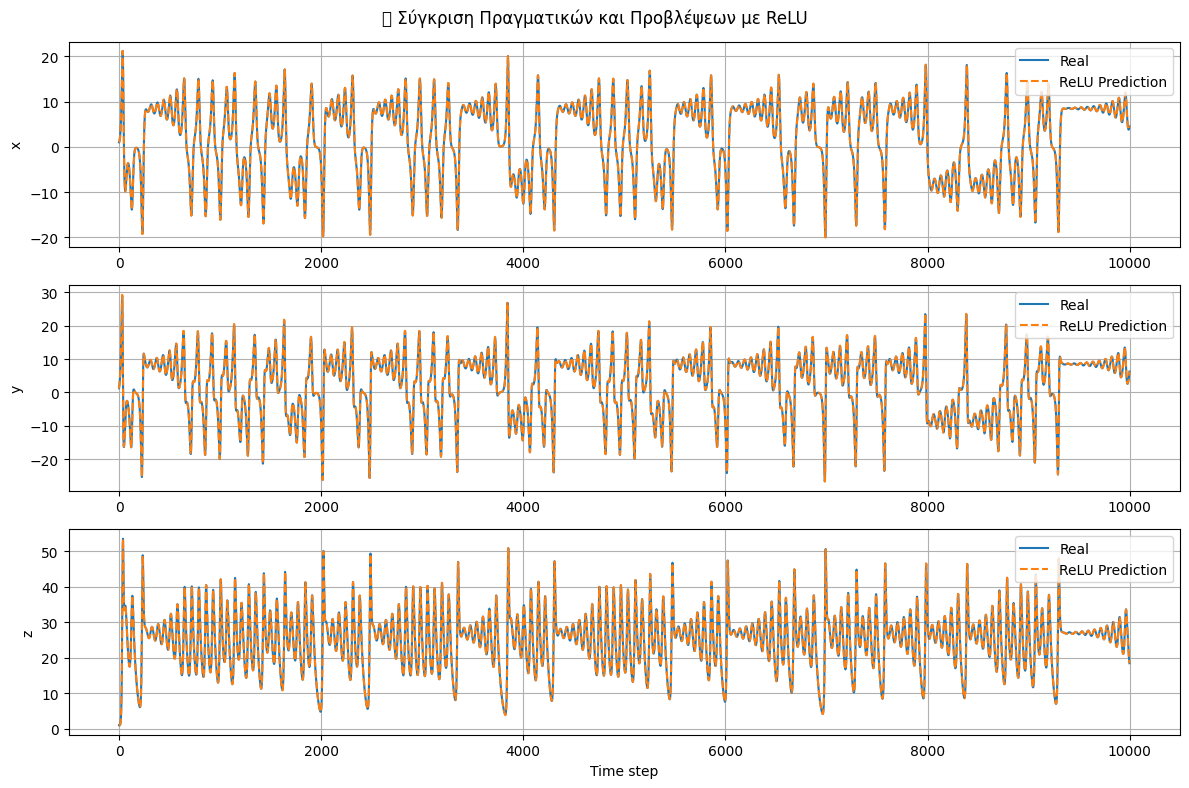

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
labels = ['x', 'y', 'z']

for i in range(3):
    axs[i].plot(actual[:, i], label='Real', linewidth=1.5)
    axs[i].plot(predictions_relu[:, i], label='ReLU Prediction', linestyle='--')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Time step')
plt.suptitle('📈 Σύγκριση Πραγματικών και Προβλέψεων με ReLU')
plt.tight_layout()
plt.show()

**Step 11: Clasic NN vs. MemNN**

/tmp/ipython-input-22-955473645.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


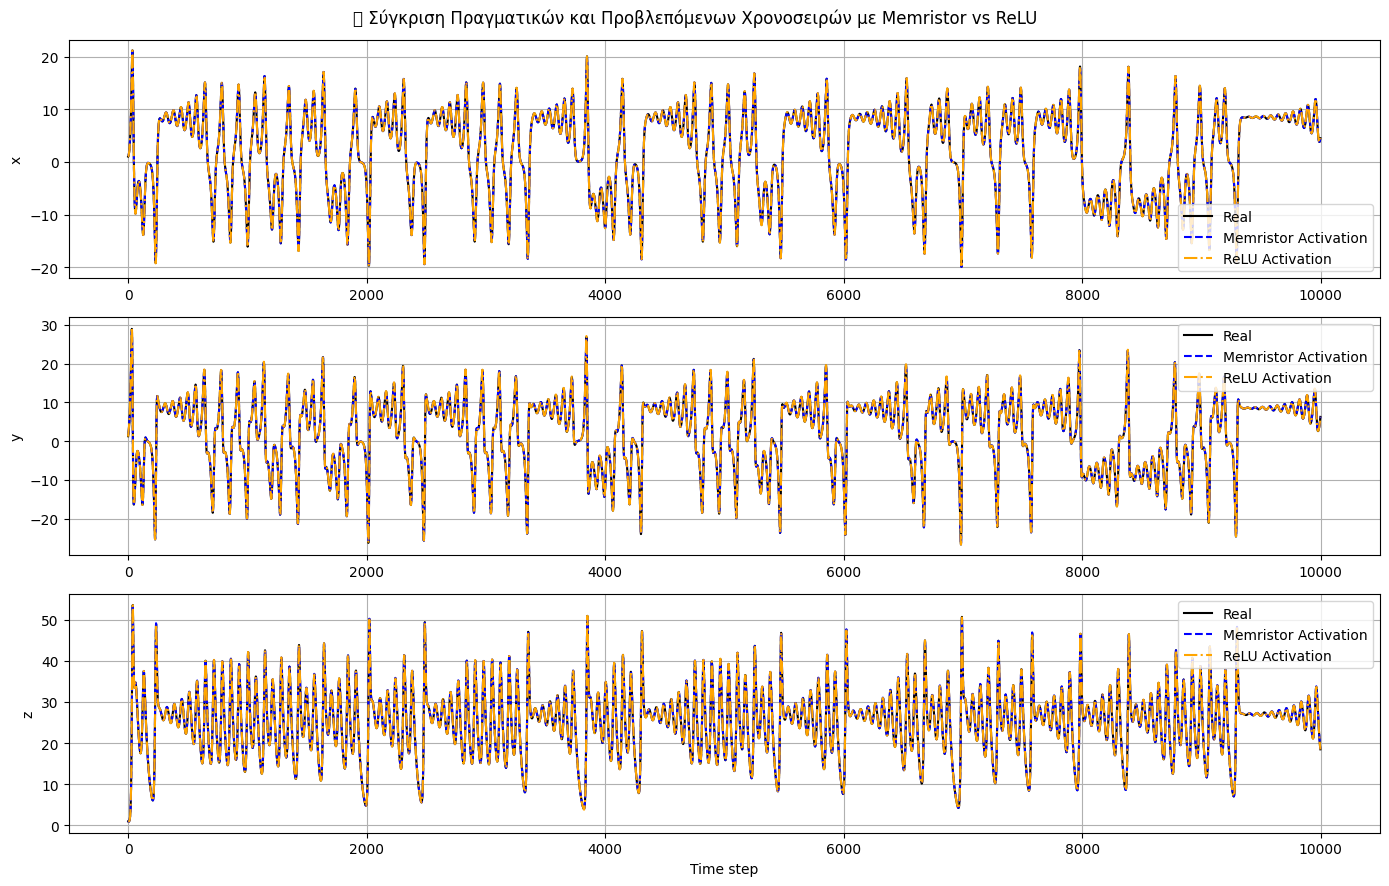


🔬 Mean Squared Error Comparison:
→ Memristor Activation:
   MSE_x = 0.002079, MSE_y = 0.003701, MSE_z = 0.003977, Total = 0.003252
→ ReLU Activation:
   MSE_x = 0.001246, MSE_y = 0.006039, MSE_z = 0.002641, Total = 0.003309


In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 9))
labels = ['x', 'y', 'z']

for i in range(3):
    axs[i].plot(actual[:, i], label='Real', linewidth=1.5, color='black')
    axs[i].plot(predictions[:, i], label='Memristor Activation', linestyle='--', color='blue')
    axs[i].plot(predictions_relu[:, i], label='ReLU Activation', linestyle='-.',  color='orange')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Time step')
plt.suptitle('📊 Σύγκριση Πραγματικών και Προβλεπόμενων Χρονοσειρών με Memristor vs ReLU')
plt.tight_layout()
plt.show()

print(f"\n🔬 Mean Squared Error Comparison:")
print(f"→ Memristor Activation:")
print(f"   MSE_x = {mse_x:.6f}, MSE_y = {mse_y:.6f}, MSE_z = {mse_z:.6f}, Total = {mse_total:.6f}")

print(f"→ ReLU Activation:")
print(f"   MSE_x = {mse_relu_x:.6f}, MSE_y = {mse_relu_y:.6f}, MSE_z = {mse_relu_z:.6f}, Total = {mse_relu_total:.6f}")


**Step 12: Team Model Memristor**

In [ ]:
import torch
import torch.nn as nn

class TEAMActivation(nn.Module):
    def __init__(self, V_on=-1.0, V_off=1.0, k_on=0.7, k_off=0.1, m=1.1, n=0.5):
        super().__init__()
        self.V_on = V_on
        self.V_off = V_off
        self.k_on = k_on
        self.k_off = k_off
        self.m = m
        self.n = n
        self.w_init = 0.5

    def forward(self, x):
        # Εισαγωγή σαν voltage
        v = torch.clamp(x, -1.0, 1.0)
        dw_dt = torch.zeros_like(v)

        # Κατώφλι OFF
        mask_off = v > self.V_off
        dw_dt[mask_off] = self.k_off * torch.pow(v[mask_off] - self.V_off, self.m)

        # Κατώφλι ON
        mask_on = v < self.V_on
        dw_dt[mask_on] = -self.k_on * torch.pow(v[mask_on] - self.V_on, self.n)

        # Ενημέρωση κατάστασης
        w = torch.clamp(self.w_init + dw_dt, 0.0, 1.0)

        # Αντίσταση ενεργοποίησης
        R = 1.0 - w  # Αναλογική έξοδος μεταξύ 0 και 1
        return R * v

**Step 13: NN with Team Model**

In [ ]:
class TEAMNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=128, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.team_act1 = TEAMActivation()
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.team_act2 = TEAMActivation()
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.team_act1(self.fc1(x))
        x = self.team_act2(self.fc2(x))
        x = self.fc3(x)
        return x

**Step 14: Training of Team model**

In [ ]:
team_model = TEAMNN()
optimizer_team = torch.optim.Adam(team_model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for epoch in range(200):
    for x_batch, y_batch in loader:
        optimizer_team.zero_grad()
        output = team_model(x_batch)
        loss = loss_fn(output, y_batch)
        loss.backward()
        optimizer_team.step()
    #print(f"[TEAM] Epoch {epoch+1}: Loss = {loss.item():.5f}")


**Step 15: Clasic NN vs. MemNN**

/tmp/ipython-input-26-4056457838.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


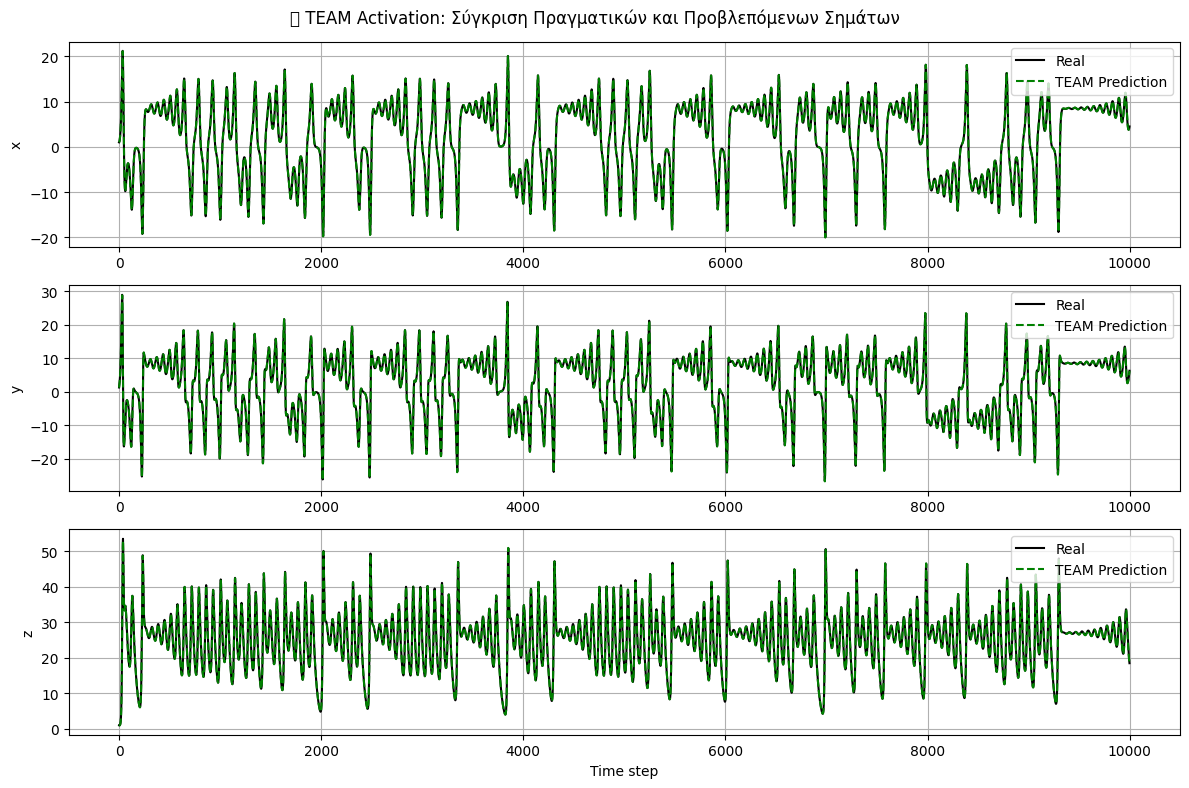

In [ ]:
# Πρόβλεψη με το εκπαιδευμένο TEAM μοντέλο
team_model.eval()
with torch.no_grad():
    predictions_team = team_model(X).numpy()
    actual = Y.numpy()

# Σχεδίαση των χρονοσειρών (x, y, z)
fig, axs = plt.subplots(3, 1, figsize=(12, 8))
labels = ['x', 'y', 'z']

for i in range(3):
    axs[i].plot(actual[:, i], label='Real', linewidth=1.5, color='black')
    axs[i].plot(predictions_team[:, i], label='TEAM Prediction', linestyle='--', color='green')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Time step')
plt.suptitle('📊 TEAM Activation: Σύγκριση Πραγματικών και Προβλεπόμενων Σημάτων')
plt.tight_layout()
plt.show()

**Step 16: TEAM MSE**

In [ ]:
team_model.eval()
with torch.no_grad():
    predictions_team = team_model(X).numpy()

# MSE υπολογισμός
mse_team_x = mean_squared_error(actual[:, 0], predictions_team[:, 0])
mse_team_y = mean_squared_error(actual[:, 1], predictions_team[:, 1])
mse_team_z = mean_squared_error(actual[:, 2], predictions_team[:, 2])
mse_team_total = (mse_team_x + mse_team_y + mse_team_z) / 3

print(f"\n📊 TEAM Mean Squared Error:")
print(f"MSE_x = {mse_team_x:.6f}, MSE_y = {mse_team_y:.6f}, MSE_z = {mse_team_z:.6f}")
print(f"Total TEAM MSE = {mse_team_total:.6f}")



📊 TEAM Mean Squared Error:
MSE_x = 0.001831, MSE_y = 0.002297, MSE_z = 0.004323
Total TEAM MSE = 0.002817


**Step 17: Comparison of all NN models**

/tmp/ipython-input-28-3952012309.py:15: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


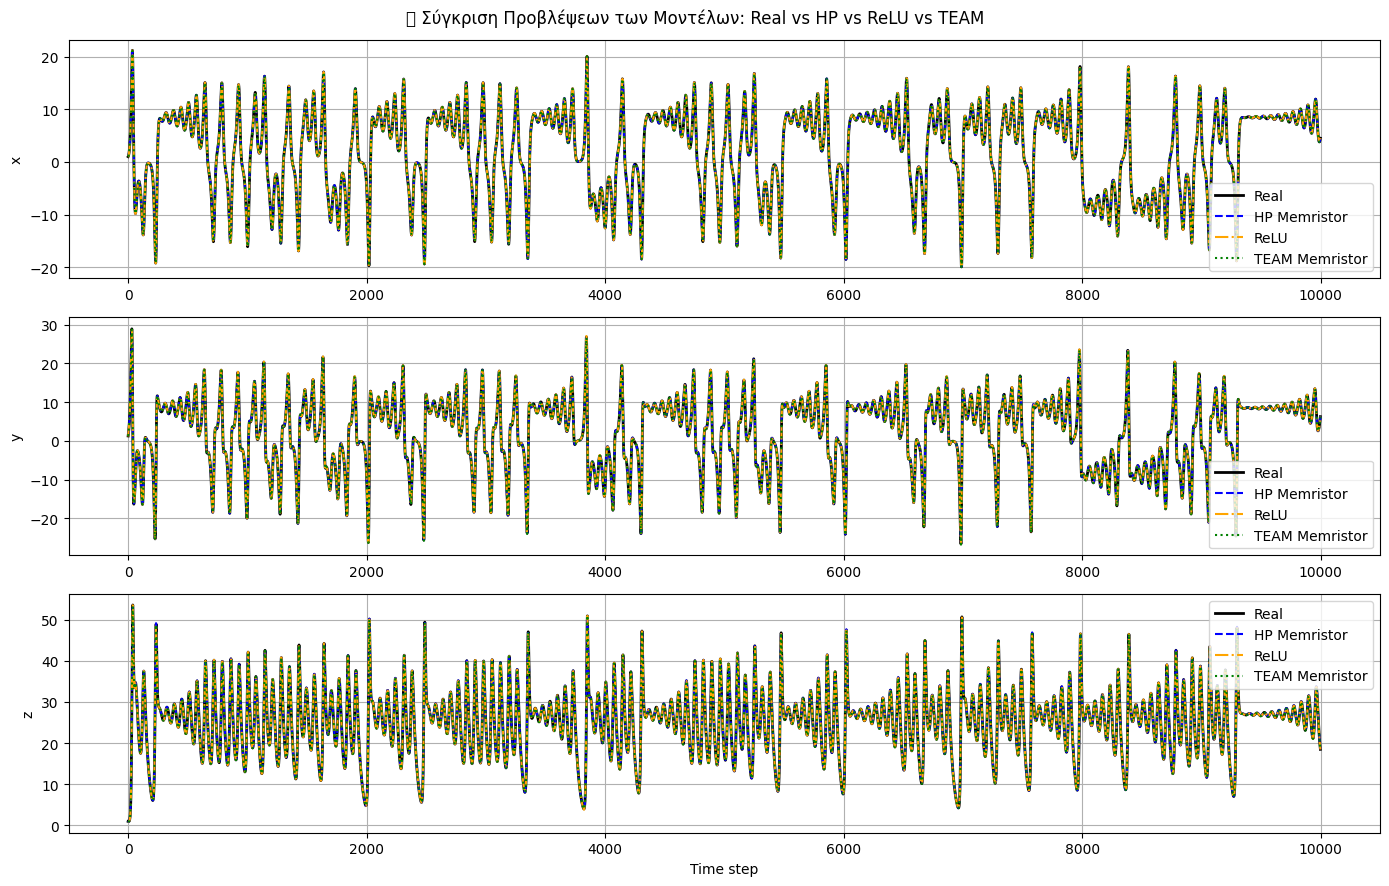


📋 Συνοπτική Σύγκριση MSE:
Μοντέλο                   MSE_x      MSE_y      MSE_z      Total
HP Memristor           0.002079   0.003701   0.003977   0.003252
ReLU                           0.001246   0.006039   0.002641   0.003309
TEAM Memristor         0.001831   0.002297   0.004323   0.002817


In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(14, 9))
labels = ['x', 'y', 'z']

for i in range(3):
    axs[i].plot(actual[:, i], label='Real', linewidth=2, color='black')
    axs[i].plot(predictions[:, i], label='HP Memristor', linestyle='--', color='blue')
    axs[i].plot(predictions_relu[:, i], label='ReLU', linestyle='-.', color='orange')
    axs[i].plot(predictions_team[:, i], label='TEAM Memristor', linestyle=':', color='green')
    axs[i].set_ylabel(labels[i])
    axs[i].legend()
    axs[i].grid(True)

plt.xlabel('Time step')
plt.suptitle('📊 Σύγκριση Προβλέψεων των Μοντέλων: Real vs HP vs ReLU vs TEAM')
plt.tight_layout()
plt.show()

print("\n📋 Συνοπτική Σύγκριση MSE:")
print(f"{'Μοντέλο':<20} {'MSE_x':>10} {'MSE_y':>10} {'MSE_z':>10} {'Total':>10}")
print(f"{'HP Memristor':<20} {mse_x:10.6f} {mse_y:10.6f} {mse_z:10.6f} {mse_total:10.6f}")
print(f"{'ReLU':<20}         {mse_relu_x:10.6f} {mse_relu_y:10.6f} {mse_relu_z:10.6f} {mse_relu_total:10.6f}")
print(f"{'TEAM Memristor':<20} {mse_team_x:10.6f} {mse_team_y:10.6f} {mse_team_z:10.6f} {mse_team_total:10.6f}")

**Step 18: New model**